<a href="https://colab.research.google.com/github/laurence-lin/Kaggle_competition/blob/master/Ashrae_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math

import sklearn
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import os

import gc
from google.colab import files
# load data from Cloud Storage
from google.colab import auth
auth.authenticate_user()

# Configure GCP project and use gsutil to copy the file from storage

!gcloud config set project 'blind-detection'
!gsutil -m cp -r gs://ashare_dataset/*.csv  sample_data/



# Reduce memory function

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16


from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


# Load all datasets and reduce memory
print(os.listdir('sample_data/'))
data_path = 'sample_data/'
train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates = ['timestamp'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates = ['timestamp'])
building = pd.read_csv(os.path.join(data_path, 'building_metadata.csv'))
weather_test = pd.read_csv(os.path.join(data_path, 'weather_test.csv'), parse_dates = ['timestamp'])
#submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
weather_train = pd.read_csv(os.path.join(data_path, 'weather_train.csv'), parse_dates = ['timestamp'])

train = reduce_mem_usage(train, use_float16 = True)
building = reduce_mem_usage(building, use_float16 = True)
weather_train = reduce_mem_usage(weather_train, use_float16 = True)
test = reduce_mem_usage(test)
weather_test = reduce_mem_usage(weather_test)




Updated property [core/project].
Copying gs://ashare_dataset/sample_submission.csv...
Copying gs://ashare_dataset/building_metadata.csv...
Copying gs://ashare_dataset/test.csv...
Copying gs://ashare_dataset/train.csv...
Copying gs://ashare_dataset/weather_test.csv...
Copying gs://ashare_dataset/weather_train.csv...
\ [6/6 files][  2.4 GiB/  2.4 GiB] 100% Done  17.4 MiB/s ETA 00:00:00           
Operation completed over 6 objects/2.4 GiB.                                      
['README.md', 'anscombe.json', 'train.csv', 'weather_train.csv', 'building_metadata.csv', 'weather_test.csv', 'test.csv', 'sample_submission.csv', 'mnist_train_small.csv', 'mnist_test.csv', 'california_housing_train.csv', 'california_housing_test.csv']
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimiz

Meter type distribution: 


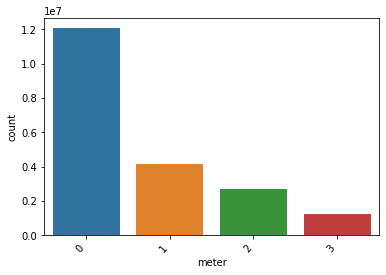

In [0]:
# EDA: Data analysis


# Observe target distribution
'''
plt.scatter(range(train.shape[0]), np.sort(train['meter_reading'].values))
plt.xlabel('Index of all measurements')
plt.ylabel('Meter Reading Values')
plt.title('Target Distributions: Increasing')
plt.show()


#plt.plot(train['meter_reading'])
plt.hist(train['meter_reading'], 
         bins = 25, #number of histograms to show up
         )
plt.show()


# Observe missing values or zeros
# train data
# Should deal with missing values here
def check_missing(df):
  total = df.isnull().sum().sort_values(ascending = False) # missing values in each feature
  percent = total / df.shape[0] * 100 # percentage of missing values in each feature
  missing_in_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percentage'])
  print(missing_in_data)

#print('Training missing: \n')
#check_missing(train)

print('Weather train missing: \n')
check_missing(weather_train)

print('Weather test missing: \n')
check_missing(weather_test)

print('Building meta missing: \n')
check_missing(building)

# Check feature correlation with target
# Should do feature selection here
corr_ = train.corr(method = 'pearson')
print('Most positive correlations:\n', corr_['meter_reading'].sort_values(ascending = False))
import seaborn as sns
sns.heatmap(corr_,
            annot = True, # write data value in each cell 
            cmap = plt.cm.RdYlBu_r, # set the color map 
            vmin = -0.25)
plt.title('Correlation heatmap')



# Show numerical feature distribution
# Should do feature transformation or processing

def plot_dist_curve(column):
  
  #Plot dist curve for weather_train & test data for given column name
  
  # I don't see the advantage dist better than hist
  fig, ax = plt.subplots(figsize = [10, 10]) # ax contains the figure elements
  sns.distplot(weather_train[column].dropna(), ax = ax).set_title(column)
  sns.distplot(weather_test[column].dropna(), ax = ax)
  plt.xlabel(column, fontsize = 15)
  plt.legend(['train', 'test']) # legend show by order of plot
  plt.show()

#plot_dist_curve('air_temperature')

# Outlier distribution
# Should detect outlier and abandon the outliers from dataset
# Outlier: the outlier of (mean value of all meter readings along the timestamp)
fig1, ax1 = plt.subplots()
y_mean_eachtime = train.groupby('timestamp').meter_reading.mean() # plot the mean value of all meter sensors in each time date
print(type(y_mean_eachtime))
#plt.plot(y_mean_eachtime.values)
y_mean_eachtime.plot(figsize = (20, 8), ax = ax1)

y_mean_eachtime.rolling(window = 10).std().plot(figsize = (20, 8))
ax1.axhline(y = .009, color = 'red')
ax1.legend(['Mean value of meter_reading each date', 'std of 10 date', 'horizontal'])
'''


#print(weather_train.isnull().sum())
#print(building.isnull().sum())
temp = train.merge(building, on = 'building_id', how = 'left')
show = temp.groupby('primary_use').size().reset_index(name = 'count')
plt.figure()
ax = sns.barplot(show['primary_use'], show['count'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 50, ha = 'right')
del temp

print('Meter type distribution: ')
show_ = train.groupby('meter').size().reset_index(name = 'count')
plt.figure(2)
ax2 = sns.barplot(show_['meter'], show_['count'])



In [0]:
temp = train.merge(building, on = 'building_id', how = 'left')
temp = temp.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')

In [8]:
# Fill missing values with mean() of each feature

def fill_missing(df):
  '''
  Fill missing values for numerical features.
  Fill in with mean() of each column
  '''

  def mean_without_nan(col):
    # ignore NaN when computing mean in column
    col /= len(col)
    return col.mean() * len(col)
  
  missing_feature = df.isnull().sum()[df.isnull().sum() > 0]
  missing_feature = list(missing_feature.index)
  feature_mean = df.loc[:, missing_feature].apply(mean_without_nan)

  for feature in missing_feature:
    if feature == 'year_built' or feature == 'floor_count':
      df[feature].fillna(math.floor(feature_mean[feature]), inplace = True)
    else:
      df[feature].fillna(feature_mean[feature], inplace = True)

  return df


Missing feature count: 

year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64
building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64


As to training data, I've about 1448 buildings to predict. 
Time scan over 3 years, each day as time step. 

Now should we rearrange the data? Each building locate in single site.
Assumption to rearrange:
1. Sort by building_id
2. Sort by time_stamp

Feature engineering:
Data cleaning: delete useless column
Data processing: standardization
Feature engineering: create new features

In [0]:
# After EDA, do feature engineering and data cleaning
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

le = LabelEncoder()

# Data Preprocessing
def preprocessing(x, building_data, weather_data, test = False):
    '''
    Preprocessing for training and testing data:
    Merge data with other two feature dataset
    Create new useful features
    Sort data by timestamp
    
    Return:
    training: X & y
    testing: X
    '''

    # Fill missing value
    # 1. Fill NaN along the time series data in each site respectively: Because timestamp in weather is consecutive
    weather_data = weather_data.groupby('timestamp').apply(lambda group: group.interpolate(limit_direction='both'))

    # Merge all feature data
    X = x.merge(building_data, on = 'building_id', how = 'left')
    X = X.merge(weather_data, on = ['site_id', 'timestamp'], how = 'left')
    X = fill_missing(X)

    # Categorical feature transformation
    X['primary_use'] = le.fit_transform(X['primary_use'])

    # Feature generation
    # 3 time feature: hour, weekday, in_holiday
    # Could validate this later
    X['timestamp'] = pd.to_datetime(X['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    X['square_feet'] = np.log1p(X['square_feet'])
    # Sort training data by timestamp
    if not test:
        X.sort_values(by = 'timestamp', inplace = True) # sort train data by time
        X.reset_index(drop = True, inplace = True)  # reset index to default that messed by sorting
    
    X['hour'] = X['timestamp'].dt.hour
    X['weekday'] = X['timestamp'].dt.dayofweek
    
    # Data Cleaning: drop useless features
    X.drop(['timestamp', 'sea_level_pressure', 'wind_direction', 'wind_speed'], axis = 1, inplace = True)
    
    # Return clean data: X & y
    if not test:
        y = np.log1p(X['meter_reading'])
        X.drop('meter_reading', axis = 1, inplace = True)
        return X, y
    elif test == True:
        row_id = X['row_id']
        X.drop('row_id', axis = 1, inplace = True)
        return X, row_id
    
## Q1: Should I do log transformation?
## Q3: There are still columns contains multiple missing values



In [0]:
# Stacking ensemble model
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

# Create training data
x_data, y_data = preprocessing(train, building, weather_train, False)
del train, weather_train

x_train, y_train, x_valid, y_valid = train_test_split(x_data, y_data, test_size = 0.3)

def stack_model():
  


estimators = [('lr', RidgeCV(random_state = 39)),
             ('randomforest', RandomForestRegressor(random_state = 39)),
             ('randomforest2', RandomForestRegressor(random_state = 42))
             ]


# Create preprocessing & model training pipeline
pipe = Pipeline(['preprocessing', preprocessing(), 'estimator', stack_model()])
#pipe.fit()
#pipe.score()

stack_model.fit(x_train, y_train,
                eval_metric = 'rmse',
                early_stopping_rounds = 200,
                verbose = 200
                )
print('Stacking score:', stack_model.score(x_valid, y_valid))


ImportError: ignored

In [0]:
# LGBM ensemble
# Use GridsearchCV to search best parameters
from sklearn.model_selection import GridSearchCV
from ligthgbm import LGBMRegressor

# Search on subset first!?
# param grid to search for best parameters
param_grid = {
    'num_leaves':[30, 45, 60],
    'max_depth':[5, 10, 20]
}

lgb = LGBMRegressor('boosting_type':'gbdt',
    'learning_rate':0.1,
    'n_estimators':800,
    'reg_lambda':2)

gridsearch= GridSearchCV(lgb, 
                         param_grid, 
                         'rmse') # score to select parameters
gridsearch.fit(x, y)
print('Best parameters selected: \n', gridsearch.best_params_)



In [0]:
# Train the whole train set by CV with best parameters selected
lgb_final = gridsearch.best_estimator_
del lgb
lgb_final.fit(
    x_train, y_train,
    eval_metric = 'rmse',
    early_stopping_rounds = 200,
    verbose = 200
)

print('LGBM score:', lgb.score(x_valid, y_valid))


del x_train, x_valid, y_train, y_valid, train_set, valid_set
gc.collect()

In [0]:
# Prediction on testing data
test_data, row_ids = preprocessing(test, building, weather_test, True)

del test, weather_test, building
gc.collect()

# Scoring test data
prediction = train_booster.predict(data = test_data 
                                   #num_iteration = train_booster.best_iteration
                                  )
# Transform back from the log1p transformation on the y_data, because our model predict on log-transformation target
prediction = np.expm1(prediction)
# limit the value minimum to zero, no negative
prediction = np.clip(prediction, a_min = 0, a_max = None)

gc.collect()

0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: int32


4

In [0]:
from sklearn.cross_validation import KFold
import numpy as np

# ensemble: stacking
class Ensemble(object):
  def __init__(self, n_fold, stacker, base_model):
      '''
      n_fold: N-fold cross stacking, n-1 for training, 1 fold for predicting
      stacker: meta model for final output
      base_model: base model as weak learner to train on n-1 fold data
      '''
      self.n_fold = n_fold
      self.stacker = stacker
      self.base_model = base_model # list of base models, could be homogeneous
  
  def fit_predict(self, X, y, T):
    '''
    fit all training data with label y, and make predictions on testing data T
    Input: training data X, and labels y
    output: prediction on testing data T, without labels
    '''
    # transform X & Y & T to array structure
    X = np.array(X) # train data
    y = np.array(y) # train labels
    T = np.array(T) # test data

    folds = list(KFold(
        len(y), # number of training samples
        n_fold = self.n_fold, 
        shuffle = True, # shuffle data before split to batches
        random_state = 9 # we could get same random sample by same training data later
    ))

    s_train = np.zeros(X.shape[0], len(self.base_model)) # input for meta model
    s_test = np.zeros(X.shape[0], len(self.base_model))  # test data prediction by each base model

    for i, clf in enumerate(self.base_model):
      s_test_i = np.zeros(T.shape[0], len(self.n_fold)) # to store predictions on testing data in each fold



